# Pipeline analysis for supervised data
Let's start simple by analyzing the data from a single individual, considering: total distance, look-around, sniffing, inner-zone time, wall-climbing, and huddle. We start by importing the necessary packages and directories.

In [17]:
import os
import pandas as pd
import pickle
import deepof.data
import deepof.visuals
import visuals_customized
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

In [2]:
# Open an existing DeepOF project
directory_output = '/home/sie/Desktop/marc/project/'
my_deepof_project = deepof.data.load_project(directory_output + "deepof_tutorial_project")

In [3]:
# Open an existing supervised analysis
with open(directory_output + 'supervised_annotation.pkl', 'rb') as file:
    supervised_annotation = pickle.load(file)

In [4]:
# Load conditions
my_deepof_project.load_exp_conditions(directory_output + 'conditions.csv')

In [5]:
# Define colors
white = '#FFFFFF'
grey_soft = '#D3D3D3'
grey_stark = '#636466'
blue = '#194680'
red = '#801946'

### Detect outliers

In [ ]:
# Detect outliers
# Detect outliers
specific_group = 'unpaired'
bin_indexs = [3]
embedding_datasets = []
for bin_index in bin_indexs:
    _, embedding_dataset, _, _ = visuals_customized.plot_embeddings(
        my_deepof_project,
        supervised_annotations=supervised_annotation,
        bin_size=60,
        bin_index=bin_index,
        my_title = '',
        my_color_dict = color_dict,
        my_coords_dict = coords_dict,
        # given_pca = pca # Uncomment to train a new pca
    )
    embedding_dataset = embedding_dataset[embedding_dataset['experimental condition'] == specific_group]
    embedding_dataset = embedding_dataset.drop('experimental condition', axis=1)
    embedding_dataset = embedding_dataset.rename(columns={'PCA-1': 'PCA_1_' + str(bin_index),
                                                          'PCA-2': 'PCA_2_' + str(bin_index)})
    
    embedding_datasets.append(embedding_dataset)
df = pd.concat(embedding_datasets, axis=1)

# Option 1: Using Z-score
from scipy.stats import zscore
z_scores = zscore(df)
abs_z_scores = abs(z_scores)

## Plot PCA between conditions

In [ ]:
# Define the coordinates for the labels of each condition
coords_dict = {
    'paired': ['Paired', [4,6]],
    'unpaired': ['Unpaired', [4,5]],
    'noshock': ['No-shock', [4,4]],    
    }

In [ ]:
# Define the colors for each condition
color_dict = {
    'paired': sns.color_palette("Set1")[0],
    'unpaired': sns.color_palette("Set1")[1],
    'noshock': sns.color_palette("Set1")[2],
    }

In [ ]:
# Filter data before plotting
new_coords = coords.filter_condition({"group": "no-shock"})

ax, embedding_dataset, dataframe_for_titles, pca = visuals_customized.plot_embeddings(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=60,
    bin_index=5,
    my_title = 'PCA tone',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict,
    # given_pca = pca # Comment to train a new pca
)

### Analyze individual PC and rotated_loading_scores

In [ ]:
# Perform statistics
import pingouin as pg
pg.normality(embedding_dataset, 'PCA-2', 'experimental condition')
pg.homoscedasticity(embedding_dataset, 'PCA-2', 'experimental condition')

x = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ee']['PCA-2']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'hc_ind']['PCA-2']
pg.ttest(x, y).round(3)

# pg.anova(embedding_dataset, 'PCA-1', 'experimental condition')
# pg.pairwise_tukey(embedding_dataset, 'PCA-1', 'experimental condition')

In [ ]:
# Save your statistics in a dictionary
stats_dict = {
    '*': ['hc_ee', 'hc_ind']
    }

In [ ]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict)

In [ ]:
# Plot the rotated loading scores of PC components
rotated_loading_scores = pca.components_
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

## Plot PCA between time points

In [15]:
# Define the coordinates for the labels of each condition
coords_dict = {
#    'bin0': ['name1', [4,5]],
#    'bin1': ['Before tone', [-4,5]],
    'bin2': ['Before tone', [2,3]],
    'bin3': ['During tone', [-3,4]],
    }

In [13]:
# Define the colors for each condition
color_dict = {
#    'bin0': sns.color_palette("Set1")[0],
#    'bin1': grey_stark,
    'bin2': grey_stark,
    'bin3': red
    }

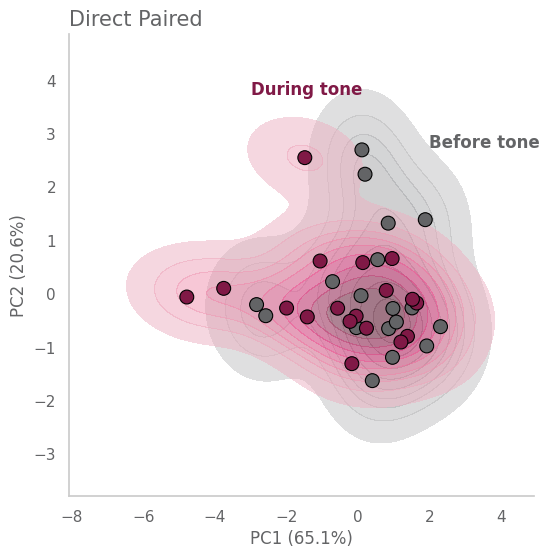

In [44]:
specific_condition = {
    'learning': 'mediated',
    'group': 'unpaired'
    }

ax, embedding_dataset, dataframe_for_titles, concat_hue, pca= visuals_customized.plot_embeddings_timelapse(
    my_deepof_project,
    supervised_annotations=supervised_annotation,
    bin_size=60,
    bin_index_list=[2,3],
    my_title = 'Direct Paired',
    my_color_dict = color_dict,
    my_coords_dict = coords_dict,
    specific_condition = specific_condition,
    given_pca = pca # Comment to train a new pca
)

### Analyze individual PC, rotated_loading_scores (across time) 

In [45]:
pg.normality(embedding_dataset, 'PCA-1', 'experimental condition')

,W,pval,normal
experimental condition,,,
bin2,0.882529,0.028796,False
bin3,0.903448,0.066001,True


In [46]:
pg.homoscedasticity(embedding_dataset, 'PCA-1', 'experimental condition')

,W,pval,equal_var
levene,0.837453,0.366571,True


In [47]:
x = embedding_dataset[embedding_dataset['experimental condition'] == 'bin2']['PCA-1']
y = embedding_dataset[embedding_dataset['experimental condition'] == 'bin3']['PCA-1']
pg.ttest(x, y, paired=True).round(3)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.734,17,two-sided,0.002,"[0.37, 1.32]",0.531,24.239,0.566


In [48]:
# Save your statistics in a dictionary
stats_dict = {
    #'': ['bin0', 'bin1'],
    #'': ['bin0', 'bin2'],
    '∗∗∗': ['Before', 'During'],
    }

<Axes: ylabel='PCA-1 eigenvalues'>

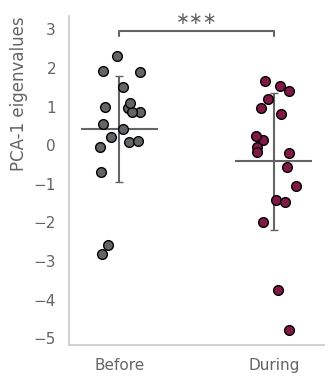

In [49]:
# Plot the PC components
visuals_customized.boxplot(embedding_dataset, color_dict, 'PCA-1', stats_dict)

<Axes: xlabel='PCA-1 rotated loading scores'>

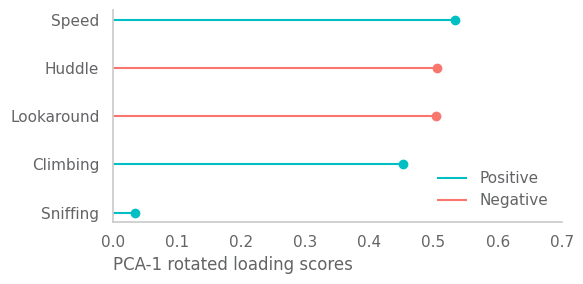

In [50]:
# Plot the rotated loading scores of PC components
rotated_loading_scores = pca.components_
visuals_customized.lollipop(dataframe_for_titles, rotated_loading_scores, 'PCA-1')

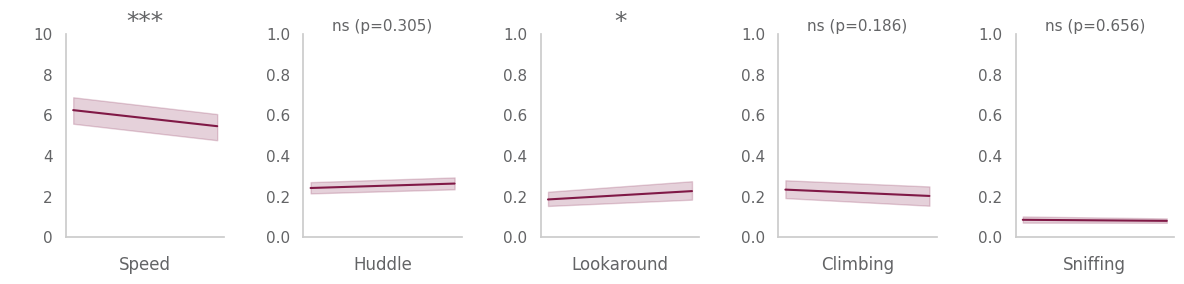

In [51]:
# Plot some individual behaviors over bins
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 3))

visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'speed', 0, 10, red, ax=ax1)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'huddle', 0, 1, red, ax=ax2)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'lookaround', 0, 1, red, ax=ax3)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'climbing', 0, 1, red, ax=ax4)
visuals_customized.timelapse(dataframe_for_titles, concat_hue, 'sniffing', 0, 1, red, ax=ax5)

plt.tight_layout()
plt.show()